In [3]:
%matplotlib inline
import sys

# Install required packages (run once). If they are already installed, this is fast.
!{sys.executable} -m pip install -q -U yfinance

import os
import datetime
import decimal

import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter

# NOTE: `matplotlib.finance` is deprecated/removed in modern Matplotlib.
# If you ever need candlesticks, use `mplfinance` instead.

# Load (or reload) our local data handler module after we write it below.


In [4]:
%%writefile data_handler.py
import pandas as pd
import yfinance as yf

class data_handler:
    """Compatibility layer for older course notebooks.

    Usage:
        from data_handler import data_handler
        raw_data = data_handler.main(tickers, start_date, end_date)

    Output format matches the old repo:
        dict[ticker] -> list of dicts with keys 'Date', 'Adj_Close', 'Volume'
    """

    @staticmethod
    def _norm_ticker(t: str) -> str:
        # Yahoo Finance: FB is now META
        return "META" if t.upper() == "FB" else t.upper()

    @staticmethod
    def main(tickers, start_date, end_date):
        norm = [data_handler._norm_ticker(t) for t in tickers]

        df = yf.download(
            norm,
            start=start_date,
            end=end_date,
            auto_adjust=False,
            progress=False
        )

        out = {}
        for orig in tickers:
            sym = data_handler._norm_ticker(orig)

            # MultiIndex columns when multiple tickers
            if isinstance(df.columns, pd.MultiIndex):
                sub = df.xs(sym, axis=1, level=1, drop_level=True).copy()
            else:
                sub = df.copy()

            price_col = "Adj Close" if "Adj Close" in sub.columns else "Close"

            rows = []
            for dt, adj in sub[price_col].dropna().items():
                vol = sub.loc[dt, "Volume"] if "Volume" in sub.columns else 0
                rows.append({
                    "Date": pd.to_datetime(dt).strftime("%Y-%m-%d"),
                    "Adj_Close": float(adj),
                    "Volume": int(vol) if pd.notna(vol) else 0
                })

            out[orig] = rows

        return out

# Also provide module-level main for convenience
def main(tickers, start_date, end_date):
    return data_handler.main(tickers, start_date, end_date)


Overwriting data_handler.py


In [5]:
import importlib
import data_handler as dh
importlib.reload(dh)
from data_handler import data_handler


In [6]:
tickers = ['WMT', 'XOM', 'FB']
start_date = '2006-02-12'
end_date = '2016-02-12'

# Based off of Part 00
raw_data = data_handler.main(tickers, start_date, end_date)
data = {}

for ticker in raw_data.keys():
    data[ticker] = []
    for row in sorted(raw_data[ticker], key=lambda x: datetime.datetime.strptime(x['Date'], '%Y-%m-%d')):
        data[ticker].append([datetime.datetime.strptime(row['Date'], '%Y-%m-%d').date(), float(row['Adj_Close'])])


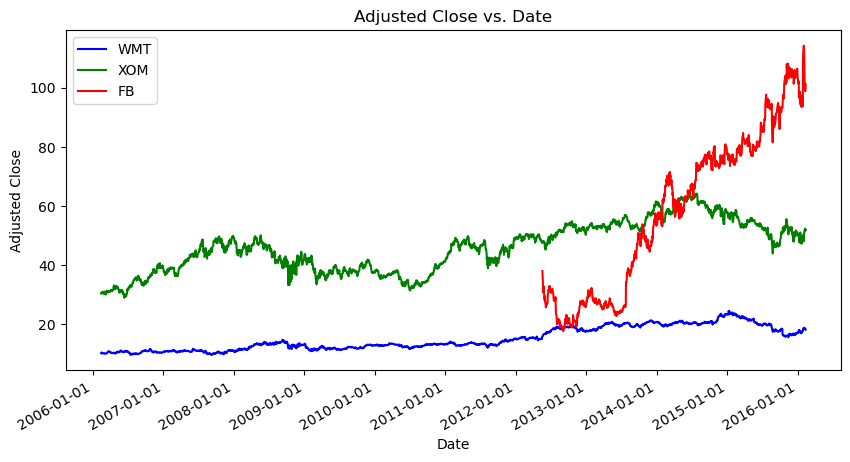

In [7]:
# Let's plot Adjusted Close vs. Date
colors = ['b', 'g', 'r', 'y']
labels = []
cnt = 0
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
handles = []
for ticker, points in data.items():
    t = [i[0] for i in points]
    adj_close = [i[1] for i in points]
    temp, = ax.plot(t, adj_close, color=colors[cnt%len(colors)], label=ticker)
    handles.append(temp)
    cnt += 1

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

ax.set_title('Adjusted Close vs. Date')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close')
try:
    ax.legend(handles=handles, loc='best')
except:
    ax.legend(handles=handles, loc='right')
fig.autofmt_xdate()

plt.show()

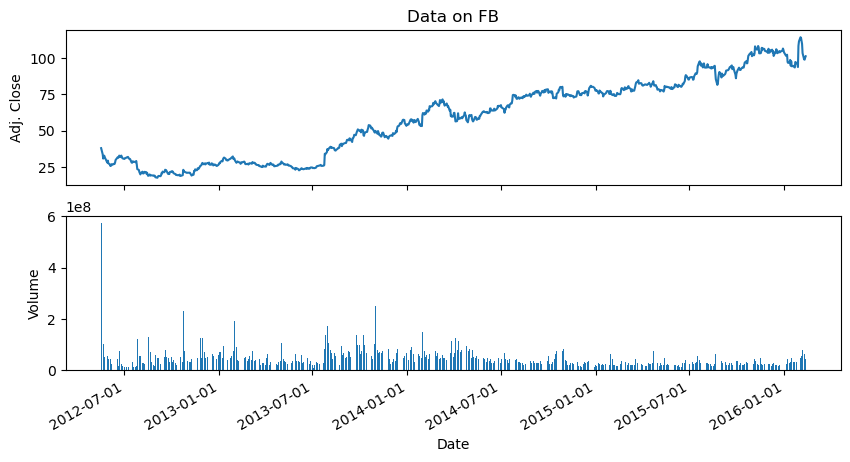

In [8]:
ticker = 'FB'
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('Data on %s'%ticker)

ax2 = fig.add_subplot(2, 1, 2)

dates = []
adj_close = []
volumes = []
for row in sorted(raw_data[ticker], key=lambda x: datetime.datetime.strptime(x['Date'], '%Y-%m-%d')):
    dates.append(datetime.datetime.strptime(row['Date'], '%Y-%m-%d').date())
    adj_close.append(float(row['Adj_Close']))
    volumes.append(int(row['Volume']))
ax1.plot(dates, adj_close)
ax1.set_ylabel('Adj. Close')

ax2.bar(dates, volumes)
ax2.xaxis.set_major_locator(AutoDateLocator())
ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')
fig.autofmt_xdate()

plt.show()

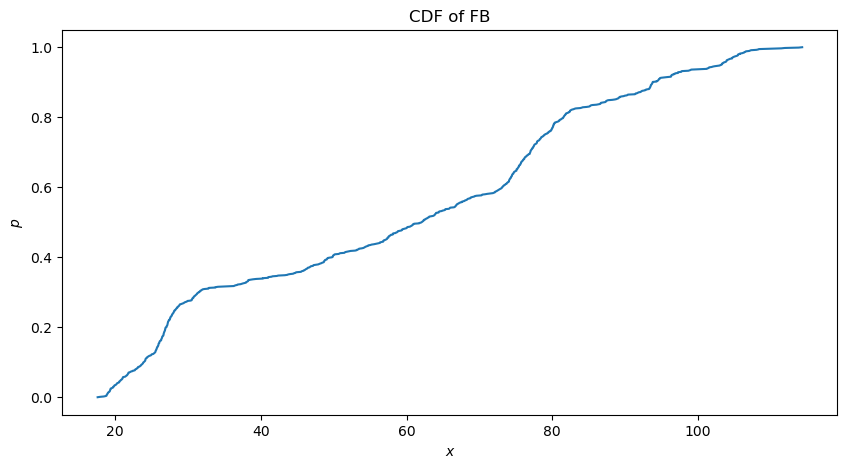

In [9]:
# What about the CDF?
import numpy as np
fb_adj_close = np.sort(np.array(adj_close))
p = 1. * np.arange(len(fb_adj_close))/(len(fb_adj_close)-1)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(fb_adj_close, p)
ax.set_ylabel('$p$')
ax.set_xlabel('$x$')
ax.set_title('CDF of FB')
plt.show()
